In [18]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.path import cart_to_joint, cart_to_joint_parallel, discretise
from ppr.ga import get_shortest_path_ga
import time
from multiprocessing import Pool

# Case 1

In [19]:
from planning_cases import robot1, path1, scene1

In [20]:
start = time.time()
path_js1 = cart_to_joint(robot1, path1, check_collision=True, scene=scene1)
end = time.time()
print("Standard function took {:.2f}s".format(end - start))

Standard function took 0.54s


In [15]:
def check_pose(pose):
    res = []
    sol = robot1.ik(pose)
    for qsol in sol['q']:
        if not robot1.check_collision(qsol, scene1):
            res.append(qsol)
    return res

def check_traj_pt(poses):
    res = []
    for pi in poses:
        res.append(check_pose(pi))
    return res

start = time.time()
tps = [discretise(tp) for tp in path1]
with Pool(processes=4) as pool:
    result = pool.map(check_traj_pt, tps)
end = time.time()
print("Parallel took {:.2f}s".format(end - start))

Parallel took 0.32s


In [21]:
sol1 = get_shortest_path_ga(path_js1, T_run=1)
print(sol1['success'])

True


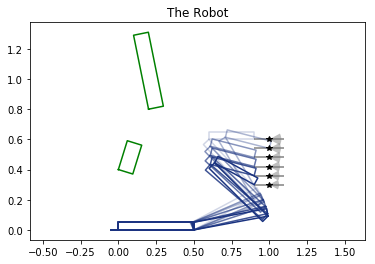

In [22]:
fig1, ax1 = plt.subplots()
plt.title("The Robot")
ax1.axis('equal')
robot1.plot_path(ax1, sol1['path'])
for tp in path1: tp.plot(ax1)
for r in scene1: r.plot(ax1, 'g')
plt.show()

## different ga settings, same problem and discretisation

In [67]:
# dijkstra global solution benchmark
from ppr.path import get_shortest_path

start = time.time()
sol_dk = get_shortest_path(path_js1)
end = time.time()
print("Dijkstra took {:.2f}s".format(end - start))

[74 74 69 67 60 59]
Dijkstra took 0.43s


In [69]:
Q = path_js1 # discretised solution space
T_max = 1.0    # fixed runtime for every ga run
N_run = 10      # how many times an experiment is repeated

# experiment design
pop_size =   [50, 100, 150, 200]
cross_rate = [0.3, 0.5, 0.7, 0.9]
mut_rate =   [0.05, 0.1, 0.2]

A = np.loadtxt("design_16_L443.txt").astype('int32')

# map 0, 1, 2, (3) in matrix A on parameter data
experiments = []
for row in A:
    experiments.append([pop_size[row[0]], cross_rate[row[1]], mut_rate[row[2]]])

# random experiment order
np.random.shuffle(experiments)
print(experiments)

# total runtime
N_run * T_max * len(experiments)

[[50, 0.3, 0.1], [150, 0.3, 0.05], [100, 0.9, 0.05], [150, 0.7, 0.05], [200, 0.3, 0.1], [150, 0.5, 0.2], [50, 0.5, 0.2], [150, 0.5, 0.05], [100, 0.9, 0.05], [100, 0.9, 0.2], [50, 0.5, 0.2], [100, 0.9, 0.2], [200, 0.7, 0.1], [200, 0.7, 0.05], [200, 0.7, 0.1], [50, 0.3, 0.1]]


160.0

In [70]:
runs = []
for run in range(N_run):
    sols = []
    for e in experiments:
        sols.append(get_shortest_path_ga(Q, T_run=T_max, cross_rate=e[1], mut_rate=e[2], pop_size=e[0]))
    runs.append(sols)

In [71]:
results = np.array([[sol['length'] for sol in run] for run in runs])
print(results)

[[ 3.05586553  2.83436894  3.4778738   2.7966857   1.39283097  1.69263172
   1.28766227  1.44332814  1.3546474   1.37913132  1.27418995  1.29612446
   1.64595771  1.35389042  1.53001106  1.4536016 ]
 [ 1.32357454  1.40374207  1.54627848  1.86417902  1.36305714  1.62576306
   1.28915143  1.62519705  1.37069082  1.55326891  1.28409123  1.28766227
   1.54947805  1.29612446  1.58155155  3.69566536]
 [ 1.5160929   1.5686326   1.50470805  1.74537945  1.17419899  1.27972329
   1.35629249  1.6881814   1.31473541  1.34888649  1.38514519  1.36056781
   2.29914236  1.28766227  1.35754466  1.48637247]
 [ 1.42752051  1.44445086  1.4496367   1.35159576  1.28818583  1.34289682
   1.2998836   1.50525045  1.68152189  1.4206655   1.37157345  1.11440814
   1.31362617  1.28915143  1.47870028  1.47870028]
 [ 1.28487802  1.29612446  1.70564699  1.66572273  1.48106408  1.41934204
   1.35886753  1.69252384  1.33865094  1.28818583  1.29612446  1.24416399
   1.29255581  2.73978519  1.29612446  1.28766227]
 [ 2.

(16,)


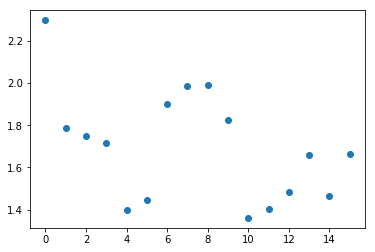

In [72]:
mean_results = np.mean(results, axis = 0)
print(mean_results.shape)
plt.plot(mean_results, 'o')
plt.show()

[1.8056997, 1.742732, 1.7341311, 1.5020005]
[1.7863996, 1.6735687, 1.581863, 1.742732]
[1.8152467, 1.6620651, 1.5872895]


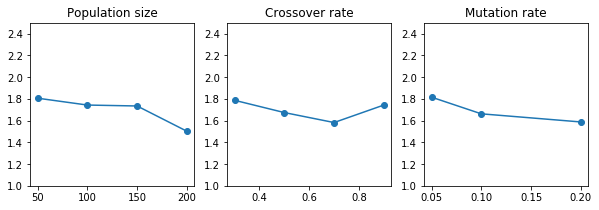

In [73]:
def calc_effect(means, levels, exp):
    effect = []
    for level in levels:
        temp = means[exp == level]
        effect.append(np.mean(temp))
    return effect
p0 = np.array([e[0] for e in experiments])
p1 = np.array([e[1] for e in experiments])
p2 = np.array([e[2] for e in experiments])

effect1 = calc_effect(mean_results, pop_size, p0)
effect2 = calc_effect(mean_results, cross_rate, p1)
effect3 = calc_effect(mean_results, mut_rate, p2)

print(effect1)
print(effect2)
print(effect3)

plt.figure(figsize=(10, 3))
ax1 = plt.subplot(131)
ax1.plot(pop_size, effect1, 'o-')
ax1.set_title("Population size")
ax1.set_ylim([1, 2.5])
ax2 = plt.subplot(132)
ax2.plot(cross_rate, effect2, 'o-')
ax2.set_title("Crossover rate")
ax2.set_ylim([1, 2.5])
ax3 = plt.subplot(133)
ax3.plot(mut_rate, effect3, 'o-')
ax3.set_title("Mutation rate")
ax3.set_ylim([1, 2.5])
plt.show()

# Case 2

In [2]:
from planning_cases import robot2, path2, scene2

In [5]:
robot2.ik_samples = [10, 10]
N_trajectory = path2[0].p[0].s * path2[0].p[2].s * len(path2)
print(N_trajectory)

print(N_trajectory * robot2.ik_samples[0] * robot2.ik_samples[1] * 8)

1200
960000


In [17]:
start = time.time()
path_js2 = cart_to_joint(robot2, path2, check_collision=True, scene=scene2)
end = time.time()
print("Standard function took {:.2f}s".format(end - start))

Standard function took 95.39s


In [25]:
def check_pose(pose):
    res = []
    sol = robot2.ik(pose)
    if sol['success']:
        for qsol in sol['q']:
            if not robot2.check_collision(qsol, scene2):
                res.append(qsol)
    return res

def check_traj_pt(poses):
    res = []
    for pi in poses:
        res.append(np.array(check_pose(pi)))
    return res

start = time.time()
tps = [discretise(tp) for tp in path2]
with Pool() as pool:
    result = pool.map(check_traj_pt, tps)
end = time.time()
print("Parallel took {:.2f}s".format(end - start))

Parallel took 29.78s


In [21]:
sol2 = get_shortest_path_ga(path_js2, T_run=5)
print(sol2['success'])

ValueError: operands could not be broadcast together with shapes (0,) (61,5) 

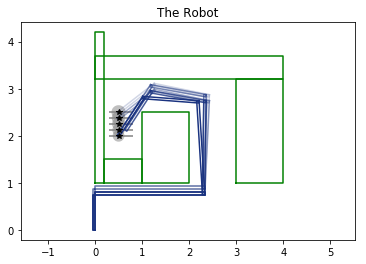

In [67]:
fig2, ax2 = plt.subplots()
plt.title("The Robot")
ax2.axis('equal')
robot2.plot_path(ax2, sol2['path'])
for tp in path2: tp.plot(ax2)
for r in scene2: r.plot(ax2, 'g')
plt.show()

## Memory analysis
With a limit of 8GB of memory, 9 dimensions with 10 samples for every dimensions seems to be the limit. When there is only one trajectory point.

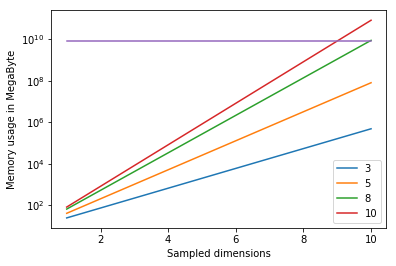

In [53]:
dims = range(1, 11)
samples = [3, 5, 8, 10]
results = []
for s in samples:
    memory_usage = np.array([s**d * 8 for d in dims])
    results.append(memory_usage)

plt.semilogy(dims, results[0],
         dims, results[1],
         dims, results[2],
         dims, results[3],
         dims, [8e9]*len(dims))
plt.xlabel("Sampled dimensions")
plt.ylabel("Memory usage in MegaByte")
plt.legend(samples)
plt.show()

## design of experiments

In [4]:
import numpy as np

In [2]:
full_factorial = 4 * 4 * 4 * 3
full_factorial

192

In [8]:
A = np.loadtxt("paretoarrays.txt")
print(A)

[[ 0.  1.  0.  1.]
 [ 3.  2.  1.  0.]
 [ 1.  2.  1.  0.]
 [ 2.  3.  3.  1.]
 [ 1.  0.  2.  1.]
 [ 1.  0.  0.  2.]
 [ 2.  0.  3.  0.]
 [ 1.  3.  3.  0.]
 [ 2.  2.  1.  0.]
 [ 0.  1.  0.  2.]
 [ 2.  2.  1.  2.]
 [ 3.  1.  2.  1.]
 [ 3.  1.  2.  2.]
 [ 0.  0.  3.  0.]
 [ 0.  3.  2.  1.]
 [ 3.  3.  0.  2.]]


In [13]:
np.vstack({tuple(row) for row in A[:, 0:2]})

array([[ 0.,  1.],
       [ 1.,  2.],
       [ 3.,  2.],
       [ 1.,  3.],
       [ 0.,  0.],
       [ 3.,  3.],
       [ 3.,  1.],
       [ 2.,  0.],
       [ 2.,  3.],
       [ 2.,  2.],
       [ 1.,  0.],
       [ 0.,  3.]])

In [17]:
print(np.vstack({tuple(row) for row in A[:, [0, 2]]}).shape)
print(np.vstack({tuple(row) for row in A[:, [0, 3]]}).shape)
print(np.vstack({tuple(row) for row in A[:, [1, 2]]}).shape)
print(np.vstack({tuple(row) for row in A[:, [1, 3]]}).shape)

(12, 2)
(12, 2)
(9, 2)
(10, 2)
